# Visualizing the Distribution of Each Feature Using Boxplots

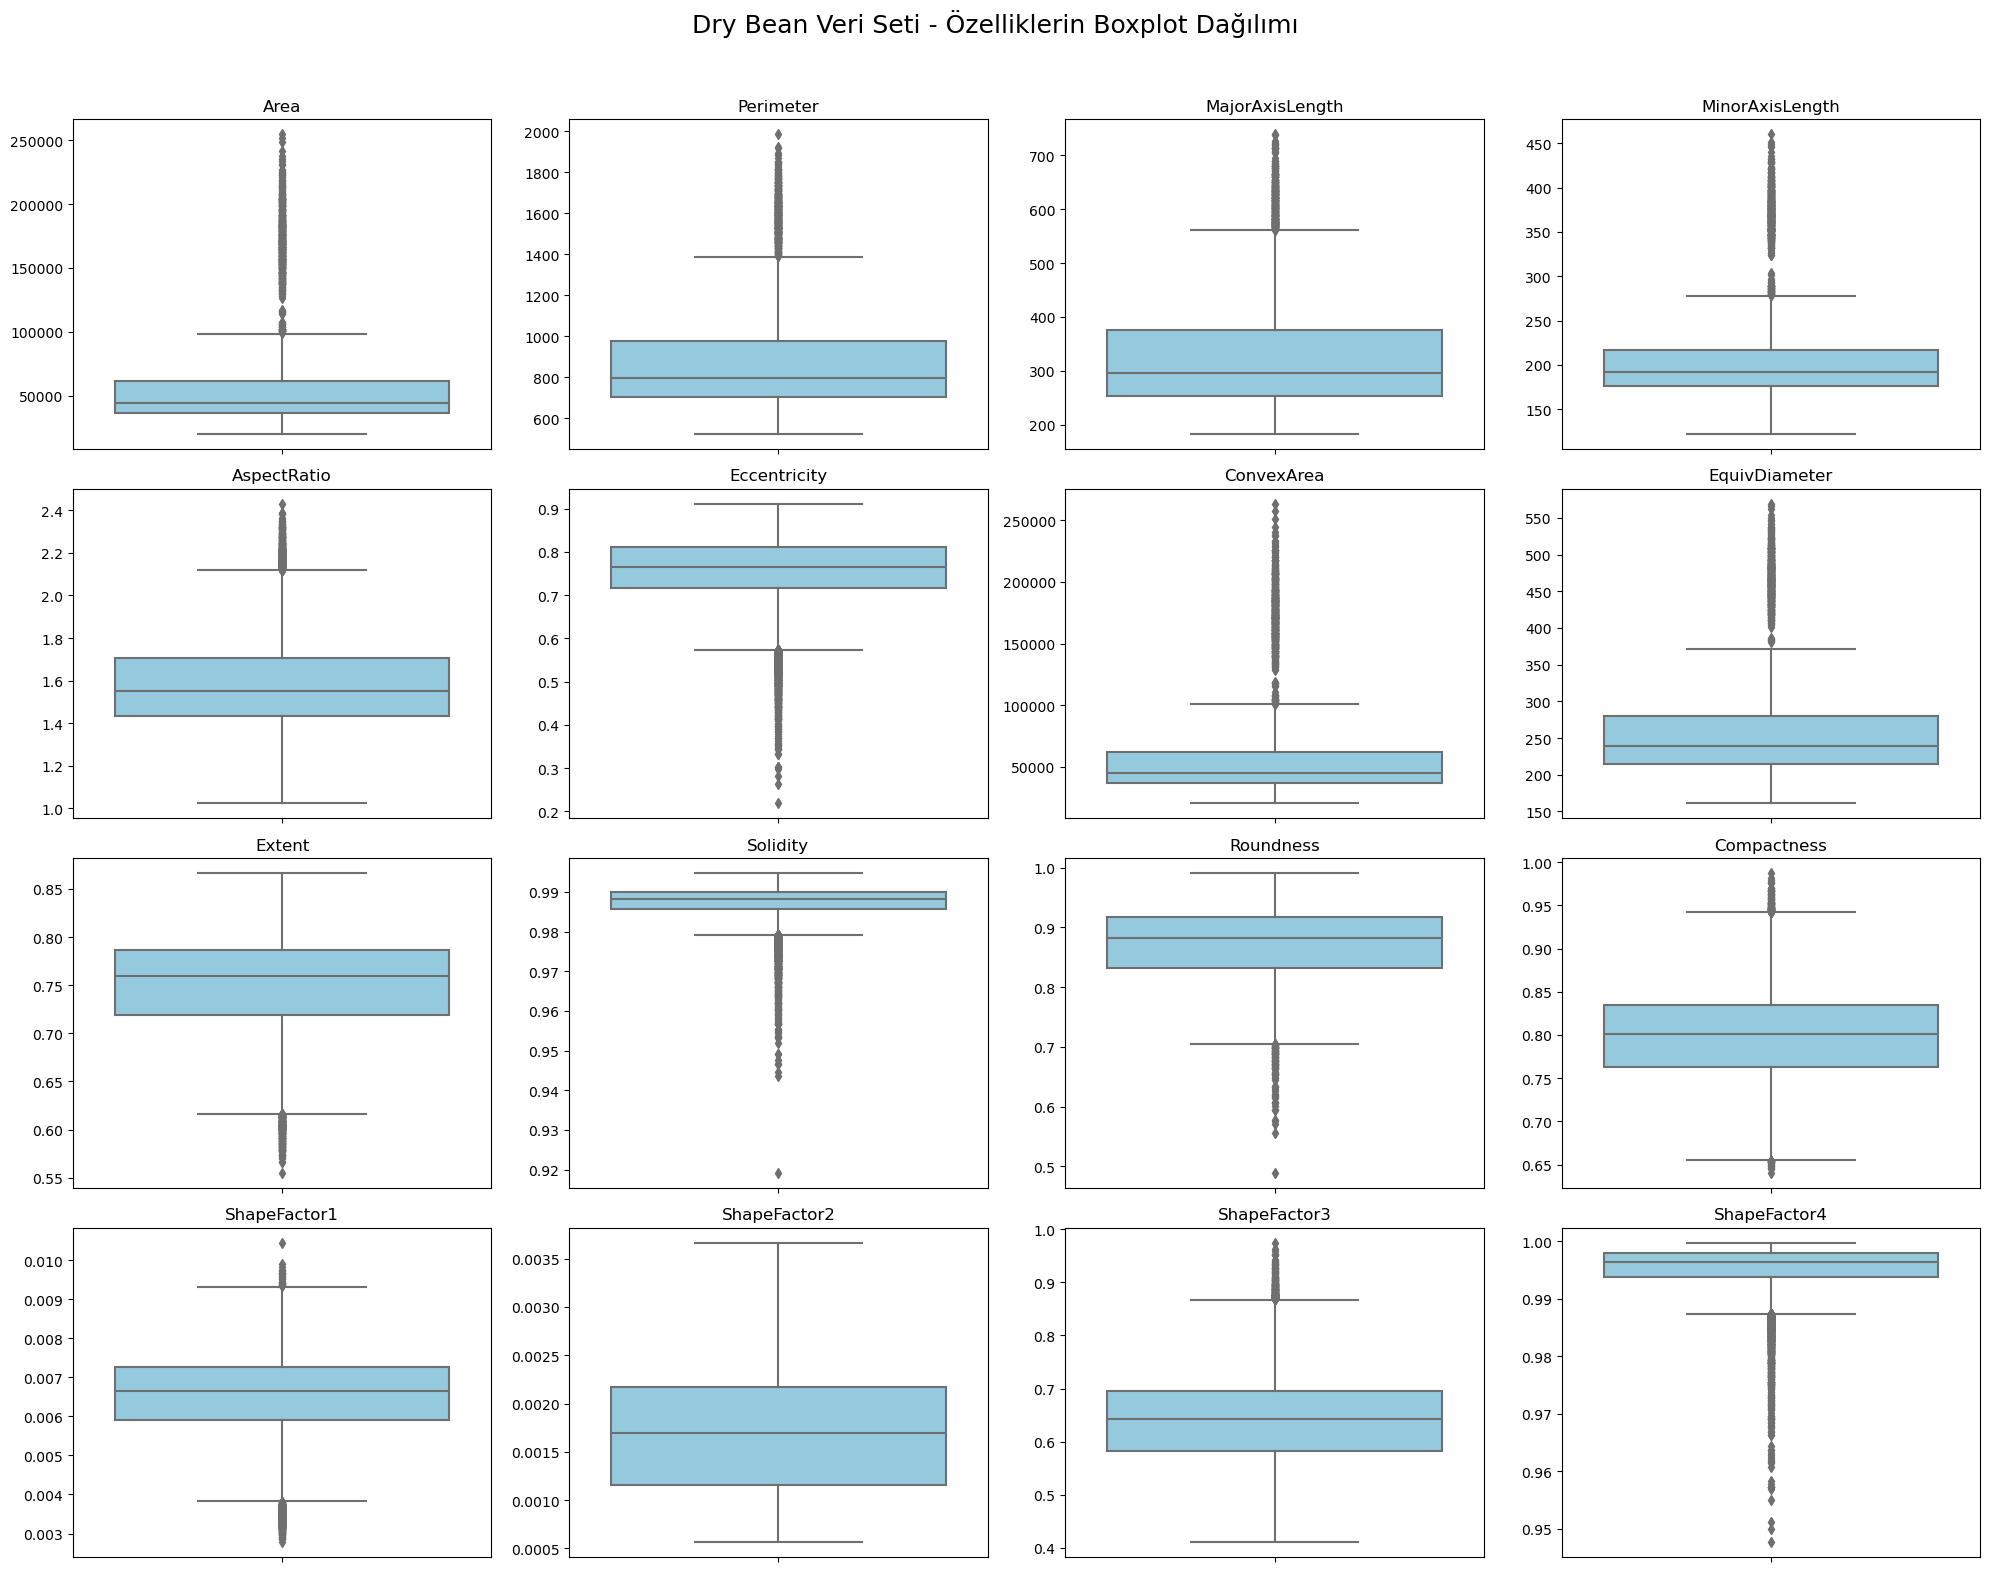

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Veriyi al
dry_bean = fetch_ucirepo(id=602)
X = dry_bean.data.features

# Subplot ayarları
features = X.columns
num_features = len(features)

# 4x4 subplot için
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
fig.suptitle("Dry Bean Veri Seti - Özelliklerin Boxplot Dağılımı", fontsize=18)

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.boxplot(y=X[feature], ax=axes[row, col], color="skyblue")
    axes[row, col].set_title(feature, fontsize=12)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Başlıkla çakışmaması için
plt.show()


In the figure above, the distributions of all 16 numerical features from the Dry Bean dataset are visualized using individual boxplots arranged in a 4x4 grid. Each plot provides insights into the spread, central tendency, and presence of outliers for the corresponding feature. The following observations can be made:

📦 Size-Based Features:
Area, ConvexArea:
These features represent the surface area of the beans. Both exhibit a large number of outliers, especially on the upper end. While the majority of the data lies between the first and third quartiles, a considerable number of values extend well beyond the whiskers. This suggests that some bean classes have significantly larger surface areas.

Perimeter, MajorAxisLength, MinorAxisLength, EquivDiameter:
These geometric measures also show a positively skewed distribution with several outliers. In particular, MajorAxisLength and EquivDiameter display a fairly symmetric spread but still contain extreme values. This may indicate varying bean shapes and sizes among classes.

🔄 Ratio-Based Geometric Features:
AspectRatio:
The data concentrates around 1.5–1.7, indicating that most beans are longer than they are wide. The distribution is slightly right-skewed.

Eccentricity:
Values range between 0.3 and 0.9, representing the degree of deviation from circularity. Some beans deviate significantly from the center.

Extent:
Most values fall between 0.6 and 0.85. There are few outliers, indicating a relatively consistent spatial coverage across instances.

Solidity:
Extremely tight distribution around 0.98 and above, with very few outliers. This feature appears to be nearly homogeneous across all samples.

🔘 Shape and Density-Based Features:
Roundness, Compactness:
These features are concentrated in the 0.7–0.9 range. Roundness displays a symmetric distribution, while Compactness is slightly left-skewed. Both contain limited outliers and low variance.

ShapeFactor1–4:
These features operate on a very small numerical scale:

ShapeFactor1 and ShapeFactor2 show values close to zero in some instances, with low overall variability.

ShapeFactor3 spans a wider range, implying more variability in certain shapes.

ShapeFactor4 is tightly centered near 1.0, showing extremely low variance, suggesting it may have limited discriminative power across classes.

📝 Overall Summary:
The highest number of outliers appear in Area, ConvexArea, and MajorAxisLength, which are all size-related features.

Shape and ratio-based features generally exhibit narrow, compact distributions.

Solidity and ShapeFactor4 demonstrate near-constant behavior, possibly reducing their usefulness in classification tasks.

This analysis helps identify features with high variance and outliers, which is essential before applying normalization techniques. In the next step, z-score normalization will be performed to standardize the feature values for better comparative analysis.



# Normalizing

In [6]:
from sklearn.preprocessing import StandardScaler

# Z-score normalizasyonu
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Normalize edilmiş veriyi tekrar DataFrame'e çevir
X_norm_df = pd.DataFrame(X_normalized, columns=X.columns)
X_norm_df["Class"] = y.values.ravel()


# Fisher Distance Function (Multiclass)

In [7]:
import numpy as np

def fisher_distance_multiclass(X_df, class_col='Class'):
    classes = X_df[class_col].unique()
    features = X_df.drop(columns=[class_col]).columns

    fisher_scores = {}

    for feature in features:
        overall_mean = X_df[feature].mean()
        Sb = 0  # Between-class scatter
        Sw = 0  # Within-class scatter

        for cls in classes:
            class_data = X_df[X_df[class_col] == cls][feature]
            n_c = len(class_data)
            mean_c = class_data.mean()
            var_c = class_data.var()

            Sb += n_c * (mean_c - overall_mean) ** 2
            Sw += n_c * var_c

        # Avoid division by zero
        fisher_score = Sb / Sw if Sw != 0 else 0
        fisher_scores[feature] = fisher_score

    return fisher_scores


In [8]:
# Fisher mesafelerini hesapla
fisher_scores = fisher_distance_multiclass(X_norm_df)

# Skorları DataFrame olarak sırala
fisher_df = pd.DataFrame.from_dict(fisher_scores, orient='index', columns=['FisherScore'])
fisher_df = fisher_df.sort_values(by='FisherScore', ascending=False)
display(fisher_df)


,FisherScore
Area,12.785163
ConvexArea,12.760548
EquivDiameter,11.214460
Perimeter,10.702661
MinorAxisLength,9.891505
MajorAxisLength,9.529474
ShapeFactor2,5.435656
ShapeFactor1,5.326117
AspectRatio,4.574205
Compactness,4.481284


# Z-Score Normalization and Fisher Distance Analysis
After applying z-score normalization to standardize the features in the Dry Bean dataset, we computed the Fisher Distance for each feature to assess its discriminative power across the 7 bean classes. The Fisher Score measures the ratio of between-class variance to within-class variance, meaning higher scores indicate features that are more effective at separating classes.

# 📊 Interpretation of Results:
The top-ranking features in terms of discriminative power are:

Area (12.78)

ConvexArea (12.76)

EquivDiameter (11.21)

Perimeter (10.70)

MinorAxisLength (9.89)

MajorAxisLength (9.52)

These are all geometric and size-related features, which intuitively makes sense, as bean types often differ in size and overall shape.

Mid-range scores are found in features like:

ShapeFactor2, ShapeFactor1, AspectRatio, Compactness, and ShapeFactor3
These features contribute moderately to class separation, especially those related to shape ratios and aspect properties.

Features with the lowest Fisher scores are:

ShapeFactor4 (0.55)

Solidity (0.28)

Extent (0.18)

These show minimal class separation and very low variance across samples, indicating that they are nearly constant across the dataset or not class-informative.

# 🧠 Conclusion:
The Fisher Distance analysis reveals that size-based attributes are the most influential in distinguishing between the 7 dry bean classes. On the other hand, features with very tight distributions and low variability (e.g., Solidity, Extent) offer little to no contribution to class separation and may be redundant or even removable in dimensionality reduction processes.



# PCA ile Dönüştürme ve Fisher Distance Karşılaştırması

In [9]:
from sklearn.decomposition import PCA

# PCA modelini kur ve tüm bileşenleri tut
pca = PCA(n_components=X.shape[1])  # 16 bileşen
X_pca = pca.fit_transform(X_normalized)

# PCA bileşenlerini DataFrame olarak al
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X.shape[1])])
pca_df['Class'] = y.values.ravel()

# PCA Eigen value'ları (açıklanan varyans oranı)
explained_variance = pca.explained_variance_ratio_


In [10]:
# Fisher Distance hesapla (PCA bileşenleri için)
fisher_pca_scores = fisher_distance_multiclass(pca_df)

# Skorları DataFrame olarak sırala
fisher_pca_df = pd.DataFrame.from_dict(fisher_pca_scores, orient='index', columns=['FisherScore'])
fisher_pca_df['ExplainedVariance'] = explained_variance
fisher_pca_df = fisher_pca_df.sort_index()
display(fisher_pca_df)


,FisherScore,ExplainedVariance
PC1,8.299457,5.546644e-01
PC10,0.217091,9.086812e-05
PC11,0.164586,6.588679e-05
PC12,0.056191,1.837393e-05
PC13,0.028351,9.299660e-06
PC14,0.003111,6.256417e-07
PC15,0.080374,1.341321e-07
PC16,0.018353,1.115495e-07
PC2,4.600933,2.643097e-01
PC3,0.072435,8.006564e-02


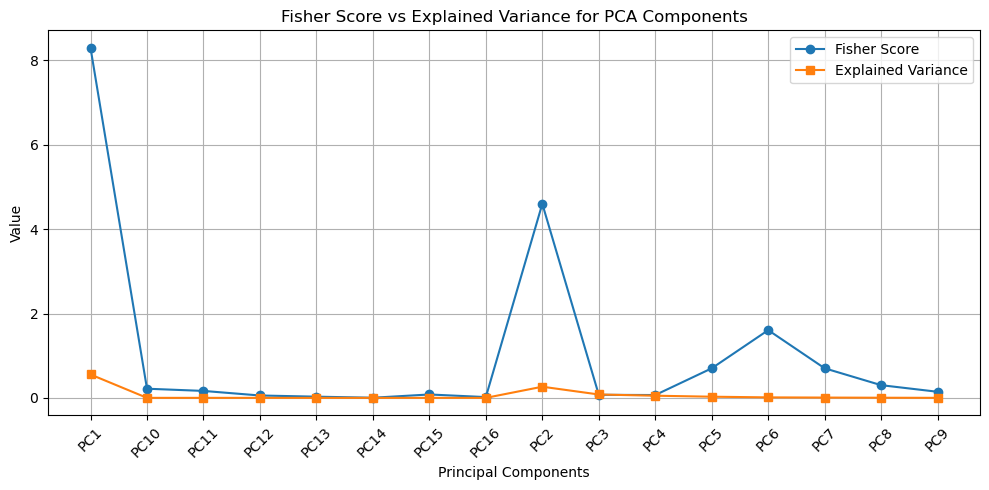

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(fisher_pca_df.index, fisher_pca_df["FisherScore"], marker='o', label="Fisher Score")
plt.plot(fisher_pca_df.index, fisher_pca_df["ExplainedVariance"], marker='s', label="Explained Variance")
plt.title("Fisher Score vs Explained Variance for PCA Components")
plt.xlabel("Principal Components")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Fisher Score vs Explained Variance – Interpretation
The graph above compares the Fisher Score (discriminative power) and the Explained Variance (information preservation) for each of the 16 Principal Components (PCs) extracted from the Dry Bean dataset.

🔍 Key Observations:
PC1 exhibits both the highest explained variance and the highest Fisher score, indicating that it captures the most information from the original dataset and is also highly effective at distinguishing between the classes.

PC2 and PC6 show moderate Fisher scores despite having relatively low explained variance, suggesting that these components capture class-relevant patterns not necessarily associated with high overall variance.

Several components such as PC10–PC15 have very low values for both Fisher score and explained variance, meaning they neither preserve much information nor contribute meaningfully to class separability.

Interestingly, PC16 has a noticeable Fisher score spike despite being the least informative in terms of explained variance. This implies it may encode subtle but class-specific features, which wouldn't be captured by variance-based filtering alone.

🧠 Conclusion:
While high variance often correlates with discriminative power, the relationship is not strictly linear.

A combined approach that considers both explained variance and Fisher distance is more effective when selecting components for downstream tasks such as classification or clustering.

For practical purposes, it would be reasonable to retain PC1, PC2, PC6, and possibly PC16 in a reduced feature set.

